In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and Preprocess Data
# We'll use the LABEVENTS and PATIENTS tables from MIMIC-III to extract SCr(Serum Creatinine) values
patients = pd.read_csv('gs://msai/aih/PATIENTS.csv.gz')
labevents = pd.read_csv('gs://msai/aih/LABEVENTS.csv.gz')

In [3]:
# Narrowing down ItemId for Creatinine values from D_LABITEMS
d_labitems = pd.read_csv('gs://msai/aih/D_LABITEMS.csv.gz')
# Filter for creatinine in D_LABITEMS
scr_itemid = d_labitems[d_labitems['LABEL'].str.contains('creatinine', case=False, na=False)]
# Display the relevant rows
print(scr_itemid[['ITEMID','LABEL','CATEGORY']])

     ITEMID                            LABEL   CATEGORY
168   50841              Creatinine, Ascites  Chemistry
239   50912                       Creatinine  Chemistry
347   51021          Creatinine, Joint Fluid  Chemistry
358   51032           Creatinine, Body Fluid  Chemistry
378   51052              Creatinine, Pleural  Chemistry
393   51067                 24 hr Creatinine  Chemistry
396   51070        Albumin/Creatinine, Urine  Chemistry
399   51073  Amylase/Creatinine Ratio, Urine  Chemistry
406   51080             Creatinine Clearance  Chemistry
407   51081                Creatinine, Serum  Chemistry
408   51082                Creatinine, Urine  Chemistry
425   51099         Protein/Creatinine Ratio  Chemistry
432   51106                 Urine Creatinine  Chemistry


In [4]:
# Filter for serum creatinine in LABEVENTS
scr_data = labevents[labevents['ITEMID'].isin(scr_itemid['ITEMID'].to_list())]
# Rename columns for clarity
scr_data.rename(columns={'VALUENUM': 'SCr'}, inplace=True)

/tmp/ipykernel_1/3084530704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scr_data.rename(columns={'VALUENUM': 'SCr'}, inplace=True)


In [5]:
# Merge with patient data to get admission times and demographics
scr_data = scr_data.merge(patients[['SUBJECT_ID', 'DOB','GENDER']], on='SUBJECT_ID', how='left')

In [6]:
# Convert CHARTTIME and DOB to datetime
scr_data['CHARTTIME'] = pd.to_datetime(scr_data['CHARTTIME'])
scr_data['DOB'] = pd.to_datetime(scr_data['DOB'])

In [7]:
# Define Baseline SCr and AKI Labels
# We'll define the baseline SCr as the minimum SCr value within the first 48 hours of admission. 
# Then, we'll label AKI based on changes in SCr.
# Sort by subject and charttime
scr_data.sort_values(by=['SUBJECT_ID', 'CHARTTIME'], inplace=True)

# Calculate baseline SCr (minimum SCr within the first 48 hours of admission)
scr_data['BASELINE_SCr'] = scr_data.groupby('SUBJECT_ID').apply(
    lambda x: x.loc[x['CHARTTIME'] <= x['CHARTTIME'].iloc[0] + pd.Timedelta(hours=48), 'SCr'].min()
).reset_index(level=0, drop=True)

# If no SCr is recorded within 48 hours, use the first recorded SCr as baseline
scr_data['BASELINE_SCr'].fillna(scr_data.groupby('SUBJECT_ID')['SCr'].transform('first'), inplace=True)

In [8]:
# Calculate change in SCr from baseline
scr_data['SCr_CHANGE'] = scr_data['SCr'] - scr_data['BASELINE_SCr']

# Define AKI stages based on KDIGO criteria
def define_aki_stage(row):
    if row['SCr_CHANGE'] >= 0.3 or row['SCr'] >= 1.5 * row['BASELINE_SCr']:
        return 1  # Stage 1
    elif row['SCr'] >= 2.0 * row['BASELINE_SCr']:
        return 2  # Stage 2
    elif row['SCr'] >= 3.0 * row['BASELINE_SCr']:
        return 3  # Stage 3
    else:
        return 0  # No AKI

scr_data['AKI_STAGE'] = scr_data.apply(define_aki_stage, axis=1)

In [9]:
print(scr_data.head(5))

    ROW_ID  SUBJECT_ID  HADM_ID  ITEMID           CHARTTIME VALUE  SCr  \
12      51           3      NaN   50912 2101-10-04 15:24:00   1.7  1.7   
13      81           3      NaN   50912 2101-10-05 06:00:00   1.6  1.6   
14     103           3      NaN   50912 2101-10-06 05:45:00   1.8  1.8   
15     120           3      NaN   50912 2101-10-07 04:30:00   1.8  1.8   
16     138           3      NaN   50912 2101-10-11 19:10:00   2.1  2.1   

   VALUEUOM      FLAG        DOB GENDER  BASELINE_SCr  SCr_CHANGE  AKI_STAGE  
12    mg/dL  abnormal 2025-04-11      M           0.6         1.1          1  
13    mg/dL  abnormal 2025-04-11      M           0.9         0.7          1  
14    mg/dL  abnormal 2025-04-11      M           0.9         0.9          1  
15    mg/dL  abnormal 2025-04-11      M           0.9         0.9          1  
16    mg/dL  abnormal 2025-04-11      M           1.2         0.9          1  


In [10]:
# Calculate and store the 10th and 90th percentiles of 'SCr' as a list to define the interquantile range.
quantiles = scr_data['SCr'].quantile([0.1,0.9]).to_list()
# Filter 'scr_data' to keep rows where 'SCr' falls within the calculated 10th-90th percentile interquantile range,
# effectively removing outliers.
scr_data_capped = scr_data[(scr_data['SCr']> quantiles[0])| (scr_data['SCr']< quantiles[1])]

In [11]:
# Feature Engineering - Extract additional features like age.
scr_data_capped['age'] = (pd.to_datetime(scr_data_capped['CHARTTIME']).dt.year - pd.to_datetime(scr_data_capped['DOB']).dt.year)

/tmp/ipykernel_1/1204154840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scr_data_capped['age'] = (pd.to_datetime(scr_data_capped['CHARTTIME']).dt.year - pd.to_datetime(scr_data_capped['DOB']).dt.year)


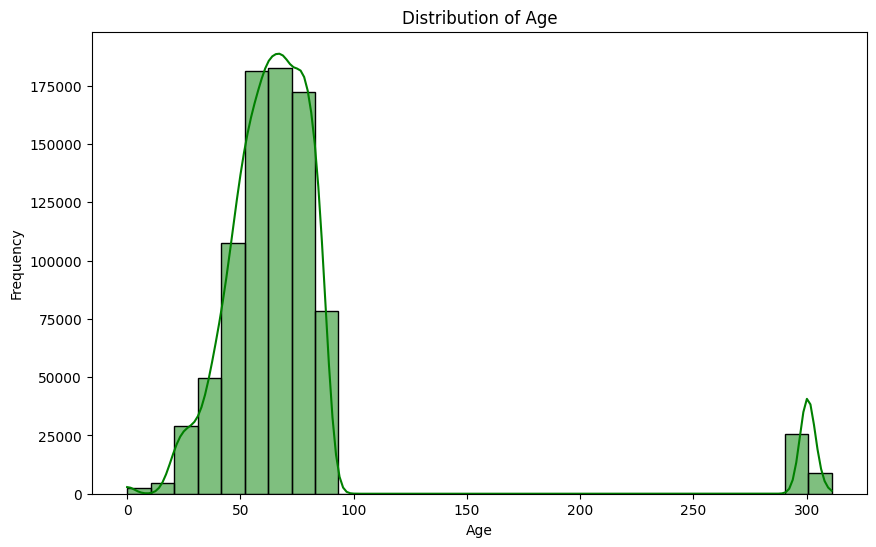

In [12]:
# Plot histogram of age
plt.figure(figsize=(10, 6))
sns.histplot(scr_data_capped['age'], bins=30, kde=True, color='green')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

/tmp/ipykernel_1/3613458960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scr_data_capped['AgeGroup'] = pd.cut(scr_data_capped['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],


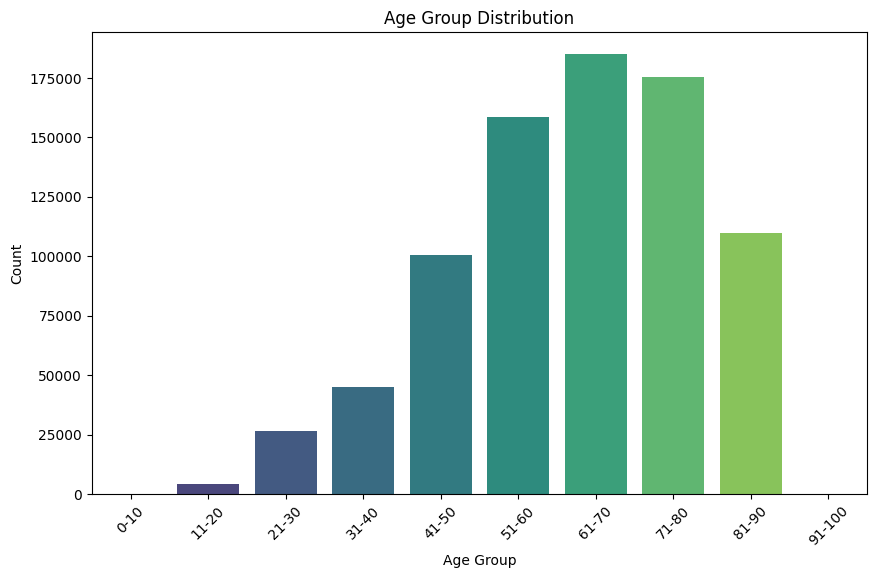

In [13]:
# Create age groups
scr_data_capped['AgeGroup'] = pd.cut(scr_data_capped['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                          labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# Plot age group distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=scr_data_capped, x='AgeGroup', palette='viridis')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

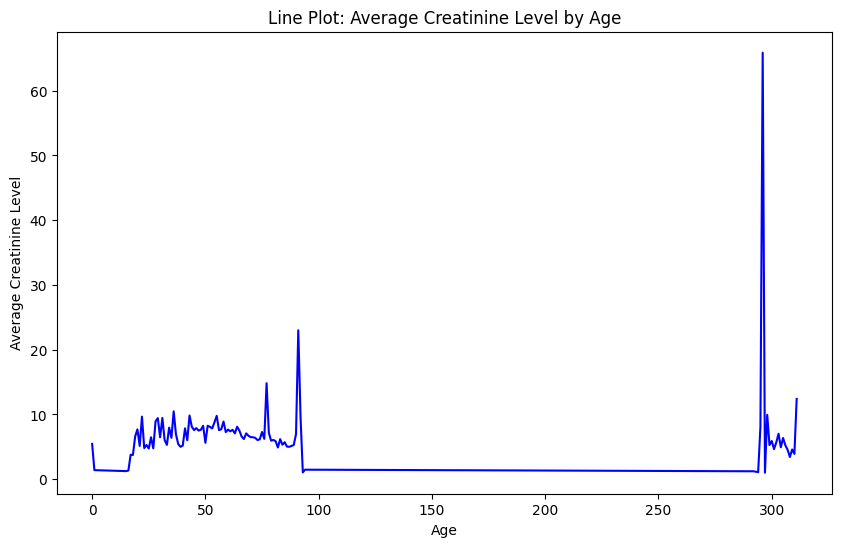

In [14]:
# Calculate average creatinine by age
avg_creatinine_by_age = scr_data_capped.groupby('age')['SCr'].mean().reset_index()

# Line plot of average creatinine by age
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_creatinine_by_age, x='age', y='SCr', color='blue')
plt.title("Line Plot: Average Creatinine Level by Age")
plt.xlabel("Age")
plt.ylabel("Average Creatinine Level")
plt.show()

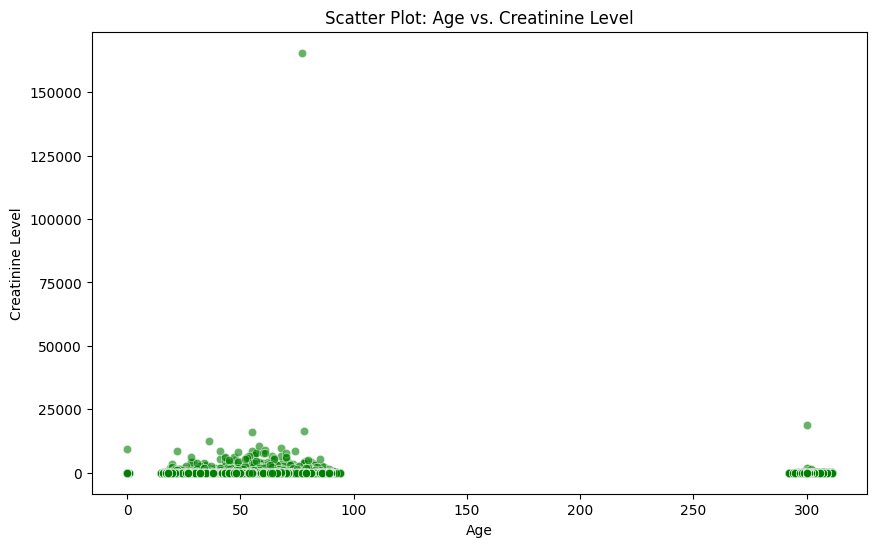

In [15]:
# Scatter plot of Age vs. Creatinine Level
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scr_data_capped, x='age', y='SCr', alpha=0.6, color='green')
plt.title("Scatter Plot: Age vs. Creatinine Level")
plt.xlabel("Age")
plt.ylabel("Creatinine Level")
plt.show()

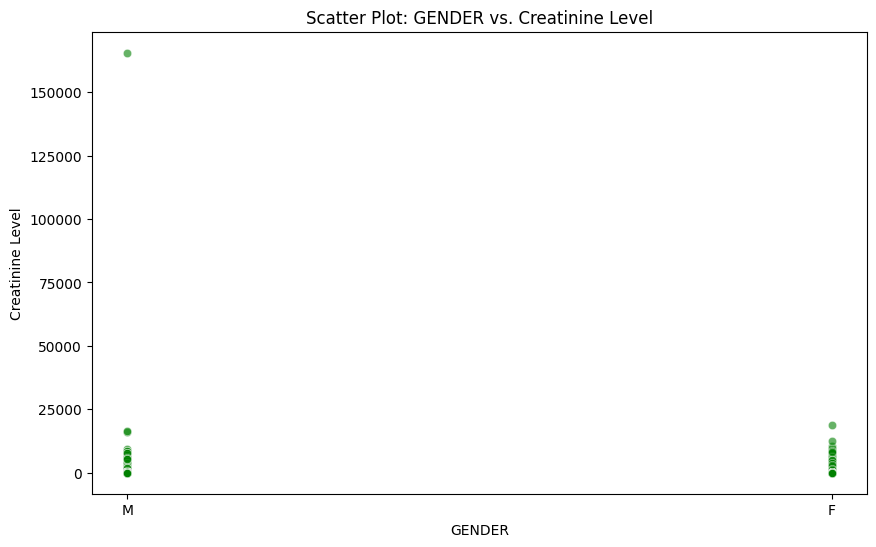

In [16]:
# Scatter plot of Age vs. Creatinine Level - count bar plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scr_data_capped, x='GENDER', y='SCr', alpha=0.6, color='green')
plt.title("Scatter Plot: GENDER vs. Creatinine Level")
plt.xlabel("GENDER")
plt.ylabel("Creatinine Level")
plt.show()

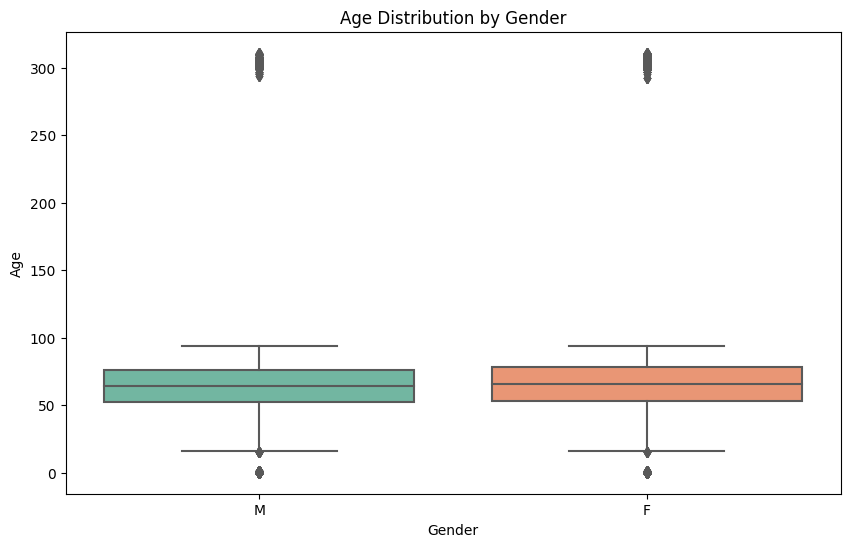

In [17]:
# Age distribution by gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=scr_data_capped, x='GENDER', y='age', palette='Set2')
plt.title("Age Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.show()

In [18]:
# Filter out ages above 300
scr_data_capped = scr_data_capped[scr_data_capped['age'] <= 100]
# Replace Scr >= 25000 with Median
scr_outliers = scr_data_capped[scr_data_capped['SCr'] >= 25000]
scr_median = scr_data_capped['SCr'].median()
scr_data_capped['SCr'] = np.where(scr_data_capped['SCr'] >= 25000, scr_median, scr_data_capped['SCr'])


In [19]:
# extract features
features = scr_data_capped.groupby('SUBJECT_ID').agg({
    'GENDER': 'first',
    'age':'first',
    'SCr': ['max', 'min', 'mean'],
    'AKI_STAGE': 'max'  # Target variable
}).reset_index()

# Flatten the multi-level column index
features.columns = ['SUBJECT_ID', 'GENDER','age', 'MAX_SCr', 'MIN_SCr', 'MEAN_SCr', 'AKI_STAGE']

# Encode gender as binary (0 for Female, 1 for Male)
features['GENDER'] = features['GENDER'].map({'F': 0, 'M': 1})

# Display the first few rows of features
print(features.head())

   SUBJECT_ID  GENDER  age  MAX_SCr  MIN_SCr   MEAN_SCr  AKI_STAGE
0           3       1   76      3.2      1.1   1.647368          1
1           4       0   48     42.0      0.4   1.962069          1
2           6       0   66    119.0      0.1  14.257778          1
3           9       1   41    130.0      1.2  17.737500          1
4          11       0   50      0.7      0.5   0.622222          1


In [20]:
len(features)

37365

            SUBJECT_ID    GENDER       age   MAX_SCr   MIN_SCr  MEAN_SCr
SUBJECT_ID    1.000000 -0.003581  0.067998 -0.025528  0.036647  0.004802
GENDER       -0.003581  1.000000 -0.054862 -0.003811  0.131626  0.005733
age           0.067998 -0.054862  1.000000 -0.004730  0.114688  0.007337
MAX_SCr      -0.025528 -0.003811 -0.004730  1.000000  0.010701  0.694562
MIN_SCr       0.036647  0.131626  0.114688  0.010701  1.000000  0.100569
MEAN_SCr      0.004802  0.005733  0.007337  0.694562  0.100569  1.000000


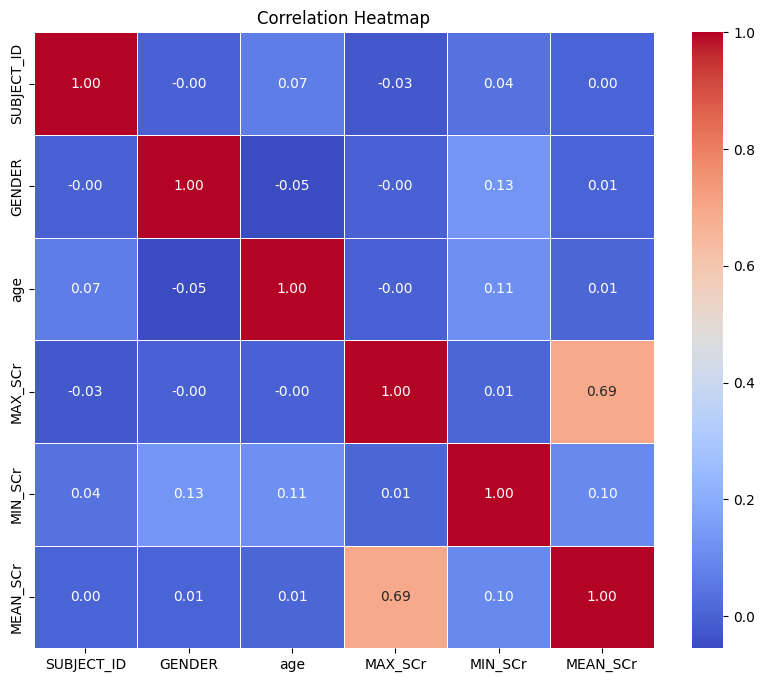

In [21]:
# Compute correlation matrix
corr_matrix = features[['SUBJECT_ID', 'GENDER', 'age','MAX_SCr', 'MIN_SCr', 'MEAN_SCr']].corr()
print(corr_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [22]:
# Step 5: Train a Machine Learning Model
# We'll use a Random Forest classifier to predict AKI.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Split data into features (X) and target (y)
X = features[[ 'GENDER', 'age', 'MIN_SCr', 'MEAN_SCr','MAX_SCr']]
y = features['AKI_STAGE'] > 0  # Binary classification: AKI (1) or no AKI (0)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

       False       0.87      0.90      0.88      5835
        True       0.88      0.85      0.87      5375

    accuracy                           0.87     11210
   macro avg       0.87      0.87      0.87     11210
weighted avg       0.87      0.87      0.87     11210

ROC-AUC Score: 0.9452526812937169


[[5230  605]
 [ 814 4561]]


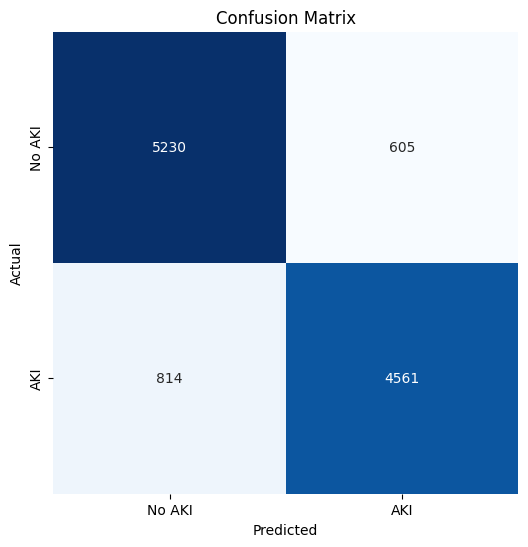

In [25]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No AKI", "AKI"], yticklabels=["No AKI", "AKI"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

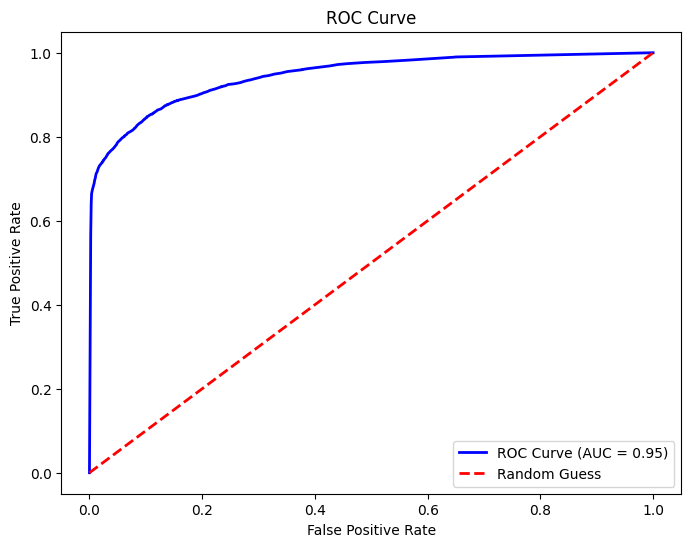

In [24]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [26]:
from xgboost import XGBClassifier

In [27]:
# Convert X_train and X_test to NumPy arrays
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Flatten X_train to 2D
X_train_flat = X_train_array.reshape(X_train_array.shape[0], -1)

# Flatten X_test to 2D (for evaluation)
X_test_flat = X_test_array.reshape(X_test_array.shape[0], -1)

In [28]:
# Train XGBoost
model = XGBClassifier(random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
model.fit(X_train_flat, y_train)

# Evaluate
y_pred = model.predict(X_test_flat)
y_pred_prob = model.predict_proba(X_test_flat)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

       False       0.87      0.92      0.89      5835
        True       0.90      0.85      0.88      5375

    accuracy                           0.88     11210
   macro avg       0.89      0.88      0.88     11210
weighted avg       0.88      0.88      0.88     11210

ROC-AUC Score: 0.9546808393615114


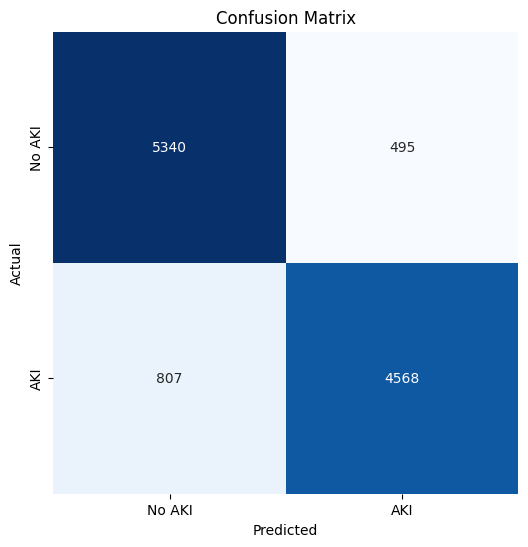

In [29]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No AKI", "AKI"], yticklabels=["No AKI", "AKI"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()